<span style="font-weight: bold; font-size: 18px;">
<p>
<b>Since the text length in the corpus is quite long, even though the language model can handle a maximum input of 8,092 tokens or even longer context, such lengthy contexts can dilute the essential information that the LLM is able to process effectively. When the input text is too long, the model may struggle to focus on the most relevant details, which can negatively impact its performance and the quality of its predictions.</b>
</p>

<p>
To address this challenge, it is beneficial to provide the language model with only the most relevant information from the large corpus, rather than overwhelming it with the entire text. By filtering and condensing the input, we can help the LLM focus on the critical content, thereby enhancing its ability to extract essential information and make more accurate predictions.
</p>

<p>
There are two main approaches to achieve this:<br>
<div style="margin-left: 20px;"><b>• Summarization:</b> Summarization techniques can be used as a form of feature extraction. By generating concise summaries of the original text, we can distill the most important points and reduce the input length, making it easier for the LLM to process and understand the core information.</div><br>
<div style="margin-left: 20px;"><b>• Retrieval-Augmented Generation (RAG):</b> This approach involves retrieving relevant information from the corpus before passing it to the language model. Techniques such as semantic search or keyword-based search (e.g., BM25) can be used to identify and extract the most pertinent sections of text. The retrieved content is then fed into the LLM, ensuring that the model receives focused and contextually relevant information for prediction.</div>
</p>

<p>
By applying either summarization or retrieval-augmented generation, we can significantly improve the efficiency and effectiveness of language models when dealing with large and complex corpora. This targeted approach helps prevent information overload and allows the model to generate more accurate and meaningful outputs.
</span>

In [1]:
# %%capture --no-stderr
# %pip install langchain langchain-openai langchain_core langgraph python-dotenv pandas numpy

## Summarization + Multi-label classification

#### you need openai-api-key to run the following script

In [2]:
import os
import re
import pandas as pd
import pickle
from typing import Annotated, List,  Optional
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnableConfig, RunnableLambda, RunnablePassthrough
from langgraph.graph import MessagesState, START, END, StateGraph
from IPython.display import display, Image
from dotenv import load_dotenv, dotenv_values

In [ ]:
###  input your openai api key into .env file in the path: _dir
_dir="/mnt/d/D-driver/langgraph"
_=load_dotenv(os.path.join(_dir, ".env"))

In [4]:
### Load Dataset for model training and evaluation ###
data_path=os.path.join(os.getcwd(), 'processed_data')
with open(os.path.join(data_path,'data.pkl'), 'rb') as f:
    df = pickle.load(f)

/tmp/ipykernel_1731408/2023378045.py:4: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  df = pickle.load(f)


In [5]:
sample_df = df[(df['word_count'] >= 500) & (df['word_count'] <= 2000)]\
    .loc[:,['full_text','postures','word_count']]\
    .sample(n=10, random_state=42).reset_index(drop=True)

In [6]:
sample_df.columns

Index(['full_text', 'postures', 'word_count'], dtype='object')

In [7]:
class Doc(TypedDict):
    id: str
    content: str
    word_count: int
    summary_length: int
    explanation_length: int
    summary: Optional[str]
    explanation: Optional[str]

class GraphState(TypedDict):
    documents: List[Doc]

def run_to_doc(df: pd.DataFrame) -> Doc:
    all_data = []
    for i in range(len(df)):
        d = df.iloc[i]
        word_count = int(d['word_count'])
        all_data.append({
            "id": i,
            "content": d['full_text'],
            "word_count": word_count,
            "summary_length": word_count // 3,
            "explanation_length": word_count // 5,
            "posture": d['postures']
        })
    
    return all_data
# Only clustering 100 documents
docs = run_to_doc(sample_df)
print(docs[0])

{'id': 0, 'content': "In a proceeding pursuant to Mental Hygiene Law article 10, Roderick L. appeals from an order of the Supreme Court, Dutchess County (Peter M. Forman, J.), dated January 13, 2017. \u2002The order, upon a finding, made after a jury trial, that Roderick L. suffers from a mental abnormality as defined in Mental Hygiene Law §\u200210.03(i) and a determination, made after a dispositional hearing, that he is a dangerous sex offender requiring civil confinement, in effect, granted the petition and directed that he be committed to a secure treatment facility for care and treatment. ORDERED that the order is affirmed, without costs or disbursements. In June 2000, the appellant was convicted, upon his plea of guilty, of attempted rape in the first degree for a sexual assault he committed on December 23, 1999, against the eight-year-old daughter of his then-girlfriend. \u2002Prior to the release of the appellant from prison, the State of New York commenced this proceeding purs

In [ ]:
_prompt="""
# Instruction

## Context
- **Goal**: You are tasked with summarizing the procedural posture for the legal document in judicial opinion or briefs.
The procedural posture of a case is a summary of how the case arrives before the court.
- **Data**: Your input data is a legal document which describes the procedural history including any prior decisions under appeal.

# Data
<data>
{content}
</data>

# Questions
## Q1. Summarize the input text in {summary_length} words or less.
Write the summary between <summary> </summary> tags.

Tips:
- The summary should contain the relevant information for the procedural posture in as much detail as possible.
- Be concise and clear. Do not add phrases like "This is the summary of the data ..." or "Summarized text: ...".
- Similarly, do not reference the user ('the user asked XYZ') unless it's absolutely relevant.
- Within {summary_length} words, include as much relevant information as possible.
- Do not include any line breaks in the summary.
- Provide your answer in **English** only.

## Q2. Explain how you wrote the summary in {explanation_length} words or less.

## Provide your answers between the tags <summary>your answer to Q1</summary>, <explanation>your answer to Q2</explanation>

# Output


"""

summary_prompt=ChatPromptTemplate.from_template(_prompt)

In [9]:
def parse_summary(xml_string: str) -> dict:
    summary_pattern = r"<summary>(.*?)</summary>"
    explanation_pattern = r"<explanation>(.*?)</explanation>"
    summary_match = re.search(summary_pattern, xml_string, re.DOTALL)
    explanation_match = re.search(explanation_pattern, xml_string, re.DOTALL)
    summary = summary_match.group(1).strip() if summary_match else ""
    explanation = explanation_match.group(1).strip() if explanation_match else ""
    return {"summary": summary, "explanation": explanation}

In [10]:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(
    model="gpt-4o",
    temperature=0.0
)

In [11]:
summary_llm_chain = (
    summary_prompt | model | StrOutputParser()
).with_config(run_name="GenerateSummary")

summary_chain = summary_llm_chain | parse_summary

def get_content(state: GraphState):
    docs = state["documents"]
    return [
        {
            "content": doc["content"],
            "summary_length": doc["summary_length"],
            "explanation_length": doc["explanation_length"]
        }
        for doc in docs
    ]

map_step = RunnablePassthrough.assign(
    summaries=get_content
    | RunnableLambda(func=summary_chain.batch, afunc=summary_chain.abatch)
)

def reduce_summaries(combined: dict) -> GraphState:
    summaries = combined["summaries"]
    documents = combined["documents"]
    return {
        "documents": [
            {
                "id": doc["id"],
                "content": doc["content"],
                "posture": doc["posture"],
                "summary": summ_info["summary"],
                "explanation": summ_info["explanation"],
            }
            for doc, summ_info in zip(documents, summaries)
        ]
    }
# This is the summary node
map_reduce_chain = map_step | reduce_summaries


In [12]:
summary_chain.invoke({"content": docs[0]["content"], 
                      "summary_length":docs[0]["summary_length"], 
                      "explanation_length":docs[0]["explanation_length"]})

{'summary': "Roderick L. appealed an order from the Supreme Court, Dutchess County, which followed a jury trial and dispositional hearing. The jury found Roderick L. to have a mental abnormality under Mental Hygiene Law § 10.03(i), and the court determined he was a dangerous sex offender requiring civil confinement. The order directed his commitment to a secure treatment facility. The appeal argued against the sufficiency of evidence and the admission of certain hearsay evidence. However, the court affirmed the order, finding the evidence legally sufficient and the verdict supported by a fair interpretation of the evidence. The court also upheld the admission of hearsay evidence related to other allegations of sexual assault, finding it reliable and probative. The court permitted the release of grand jury minutes and the admission of a written report from an unavailable expert. The court's finding of Roderick L.'s dangerousness was supported by clear and convincing evidence, justifying

### Graph Execution

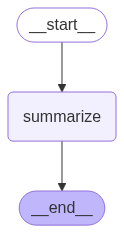

In [13]:
graph=StateGraph(GraphState)
graph.add_node("summarize", map_reduce_chain)
graph.add_edge(START, "summarize")
graph.add_edge("summarize",END)
app=graph.compile()
display(Image(app.get_graph().draw_mermaid_png()))

In [14]:
summarization=app.invoke({"documents":docs})

In [17]:
final_result=pd.DataFrame(summarization["documents"])
final_result

,id,content,posture,summary,explanation
0,0,In a proceeding pursuant to Mental Hygiene Law...,On Appeal,"Roderick L. appeals from a Supreme Court, Dutc...","To write the summary, I focused on capturing t..."
1,1,Defendant-appellant Ronald Epps appeals from a...,"Appellate Review, Trial or Guilt Phase Motion ...",Defendant-appellant Ronald Epps appeals from a...,"In writing the summary, I focused on capturing..."
2,2,"Proceeding pursuant to CPLR article 78, in eff...",Review of Administrative Decision,The case involves a CPLR article 78 proceeding...,I wrote the summary by focusing on the procedu...
3,3,"In an action, inter alia, to recover damages f...","Motion to Dismiss, On Appeal",In a legal action involving claims of conversi...,I wrote the summary by focusing on the procedu...
4,4,Appeal from an order of the Family Court of Ch...,On Appeal,This case is an appeal from a Family Court ord...,"I focused on the procedural history, detailing..."
5,5,¶ 1 Travis Padgett appeals trial court orders ...,Appellate Review,Travis Padgett appealed trial court orders den...,"To write the summary, I focused on capturing t..."
6,6,Desima James appeals his 63-month sentence aft...,"Appellate Review, Sentencing or Penalty Phase ...",Desima James appealed his 63-month sentence af...,"To write the summary, I focused on capturing t..."
7,7,It is hereby ORDERED that the judgment so appe...,Appellate Review,The procedural posture of the case involves th...,"In writing the summary, I focused on capturing..."
8,8,Appeal from a judgment of the Supreme Court (N...,"On Appeal, Review of Administrative Decision","Petitioner, a Connecticut resident, had his Ne...",I focused on the key procedural events: the re...
9,9,In an action to recover damages for personal i...,On Appeal,"In a personal injury case, the plaintiff appea...",I focused on summarizing the procedural histor...


In [19]:
row_idx = 0  
row = final_result.iloc[row_idx]

import textwrap
print("="*40)
print("Original Content:\n")
print( textwrap.fill(row['content'], width=100))
print("\n" + "="*40)
print("Summary:\n")
print( textwrap.fill(row['summary'], width=100))
print("\n" + "="*40)
print("Explanation:\n")
print( textwrap.fill(row['explanation'], width=100))
print("="*40)

Original Content:

In a proceeding pursuant to Mental Hygiene Law article 10, Roderick L. appeals from an order of the
Supreme Court, Dutchess County (Peter M. Forman, J.), dated January 13, 2017.  The order, upon a
finding, made after a jury trial, that Roderick L. suffers from a mental abnormality as defined in
Mental Hygiene Law § 10.03(i) and a determination, made after a dispositional hearing, that he is a
dangerous sex offender requiring civil confinement, in effect, granted the petition and directed
that he be committed to a secure treatment facility for care and treatment. ORDERED that the order
is affirmed, without costs or disbursements. In June 2000, the appellant was convicted, upon his
plea of guilty, of attempted rape in the first degree for a sexual assault he committed on December
23, 1999, against the eight-year-old daughter of his then-girlfriend.  Prior to the release of the
appellant from prison, the State of New York commenced this proceeding pursuant to Mental Hyg